In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import numpy as np


In [2]:
test_image='../test_images/test1.jpg'

Image size: (720, 1280, 3)


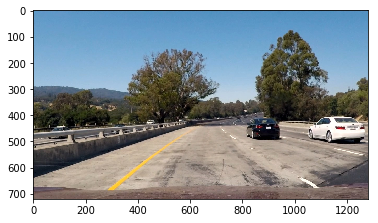

In [3]:
image=cv2.cvtColor(cv2.imread(test_image),cv2.COLOR_BGR2RGB)
plt.imshow(image)
print("Image size: {}".format(image.shape))

Scale down the image by 4


New image size: (360, 640, 3)


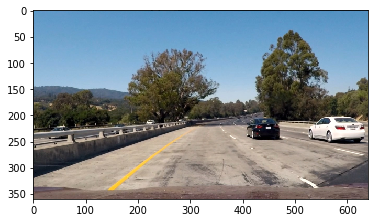

In [4]:
image_scaled=cv2.resize(image,None,fx=0.5,fy=0.5)
plt.imshow(image_scaled)
print("New image size: {}".format(image_scaled.shape))

As we can see from above image, this looks large enough to run the vehicle detection

Set the top and bottom threshold:

In [5]:
detection_area=((0,170),(640,320))

Show the threshold rectangle

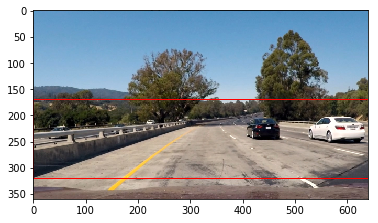

In [6]:
detection_rect=np.copy(image_scaled)
plt.imshow(cv2.rectangle(detection_rect,detection_area[0],detection_area[1], color=(255,0,0),thickness=1))

32x32 Image Windows

Observing the image above, we can assume that cars far away look smaller and the close ones look larger.

Likewise, we can set different thresholds for 32x32, 64x64  windows

In [15]:
overlap=0.5
window_sizes=[32,64,128]
slide_thresholds=[(200,200+int(3*32/2)),(200,200+int(2*64/2)),(180,180+int(1*128/2))]
# window_sizes=[64]
# slide_thresholds=[(200,200+int(2*64/2)),(180,180+int(1*128/2))]


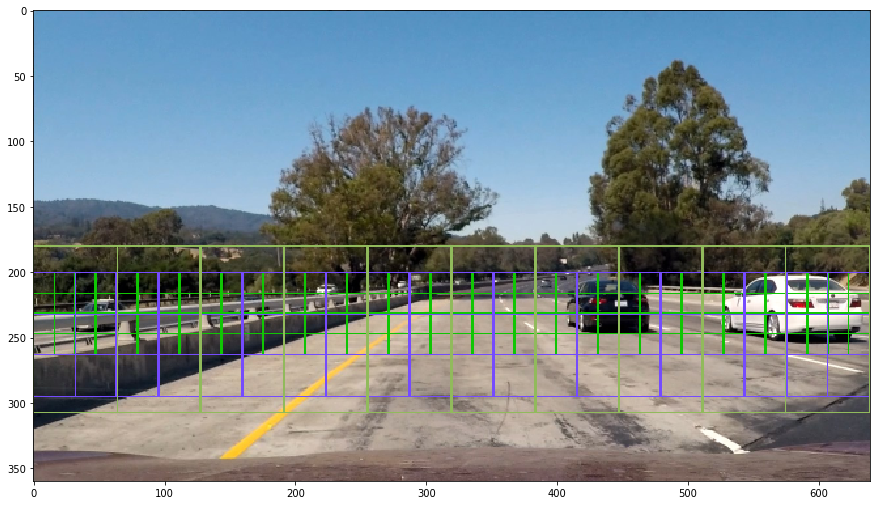

In [16]:
windows=np.copy(image_scaled)
windos_rects=[]
for i in range(len(window_sizes)):
    window_size = window_sizes[i]
    color=np.random.randint(0,255,size=(3,)).astype(np.float64)
    for row in range(slide_thresholds[i][0],slide_thresholds[i][1],int(window_size*overlap)):
        for col in range(0,image_scaled.shape[1]-window_size,int(window_size*overlap)):
            cv2.rectangle(windows,(col,row),(col+window_size-1,row+window_size-1),color,thickness=1)
            windos_rects.append(((col,row),(col+window_size-1,row+window_size-1)))
#         Handle the last window column
        cv2.rectangle(windows,(image_scaled.shape[1]-window_size,row),(image_scaled.shape[1]-1,row+window_size-1),color,1)
        windos_rects.append(((image_scaled.shape[1]-window_size,row),(image_scaled.shape[1]-1,row+window_size-1)))
fig=plt.figure(figsize=(15,10))
plt.imshow(windows)

Run SVM on windows

In [17]:
from sklearn import svm
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

In [18]:
model=joblib.load('model_svm2.pkl')
scaler=joblib.load('stdscaler2.pkl')

In [19]:
# from skimage.feature import hog
# def get_features(img,cell_per_block=2,pix_per_cell=8,orient=9, colorspace='HSV', color_hist_bins=16, img_resize=(32,32)):
# #     returns the feature vector for the image
#     if(img_resize != (img.shape[0]),img.shape[1]):
#         img=cv2.resize(img,img_resize)
# #     get hog features before colorspace conversion
#     feat=hog(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=True)
# #     Convert to required colorspace
#     if(colorspace!='BGR'):
#         if(colorspace=='HSV'):
#             img=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
#         elif(colorspace=='HLS'):
#             img=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
#         else:
#             pass    
#     for i in range(3):
# #         loop over three channels
#         ch_hist = np.histogram(img[:,:,i],bins=color_hist_bins,range=(0,256))[0]
#         feat = np.concatenate((feat,ch_hist))
#     return feat

In [20]:
from skimage.feature import hog

def get_features(img,cell_per_block=2,pix_per_cell=8,orient=9, color_hist_bins=32, img_resize=(32,32)):
#     returns the feature vector for the image
    if(img_resize != (img.shape[0]),img.shape[1]):
        img=cv2.resize(img,img_resize)
#     get hsv image:
    img_hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
#     get hog features for v channel
    feat=hog(img_hsv[:,:,2], 
             orientations=orient, 
             pixels_per_cell=(pix_per_cell, pix_per_cell), 
             cells_per_block=(cell_per_block, cell_per_block), 
             visualise=False, feature_vector=True)
#     Histogram of V & S channels only
    for i in range(1,3):
#         loop over three channels
        ch_hist = np.histogram(img[:,:,i],bins=color_hist_bins,range=(0,256))[0]
        feat = np.concatenate((feat,ch_hist))
    return feat

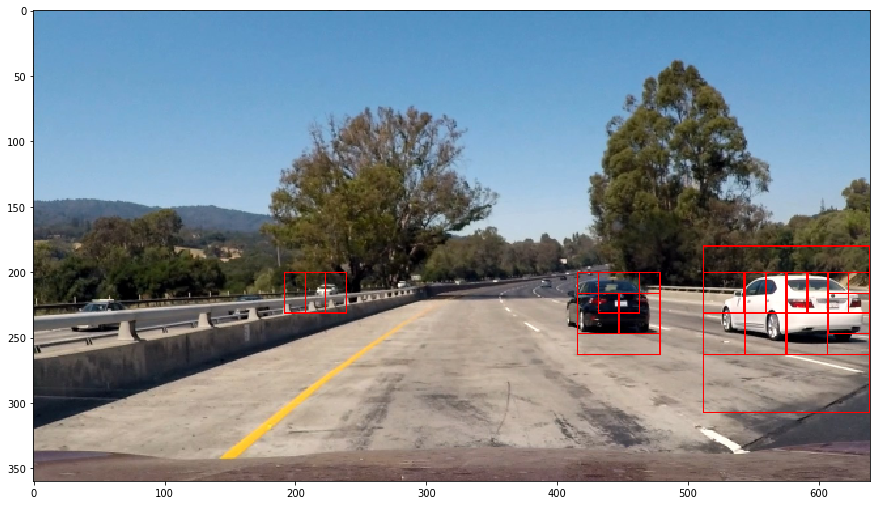

In [21]:
test_image='../test_images/test6.jpg'
cv2.cvtColor(cv2.imread(test_image),cv2.COLOR_BGR2RGB)
image_scaled=cv2.resize(image,None,fx=0.5,fy=0.5)

detection_image=np.copy(image_scaled)

for _win in windos_rects:
    _img=np.copy(image_scaled[_win[0][1]:_win[1][1]+1, _win[0][0]:_win[1][0]+1,:])
#     Get the features
    _feats=scaler.transform(get_features(_img).reshape(1,-1))
    pred=model.predict(_feats.reshape(1,-1))
    if pred == 1:
        cv2.rectangle(detection_image,_win[0],_win[1],(255,0,0),1)
fig=plt.figure(figsize=(15,10))
plt.imshow(detection_image)

In [22]:
# Process Video func
def process_video(frame):
#     Assumes RGB frame:
    image_scaled=cv2.resize(frame,(640,360))
    detection_image=np.copy(image_scaled)
    for _win in windos_rects:
        _img=np.copy(image_scaled[_win[0][1]:_win[1][1]+1, _win[0][0]:_win[1][0]+1,:])
    #     Get the features
        _feats=scaler.transform(get_features(_img).reshape(1,-1))
        pred=model.predict(_feats.reshape(1,-1))
        if pred == 1:
            cv2.rectangle(detection_image,_win[0],_win[1],(255,0,0),1)
    return detection_image

In [23]:
# Test on video;
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
out_file="video_test.mp4"
%time white_clip.write_videofile(out_file, audio=False)


[MoviePy] >>>> Building video video_test.mp4
[MoviePy] Writing video video_test.mp4


100%|█████████▉| 1260/1261 [03:27<00:00,  6.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_test.mp4 

CPU times: user 5min 54s, sys: 1.32 s, total: 5min 55s
Wall time: 3min 27s


In [24]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_file))